## Install and import dependencies

In [1]:
!pip3 install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (4.0.1)


In [2]:
# Import tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the fashion MNIST model

In [5]:
dataset, metadata = tfds.load("fashion_mnist", as_supervised=True, with_info=True)

In [6]:
dataset

{'test': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 'train': <PrefetchDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}

In [7]:
train_dataset, test_dataset = dataset["train"], dataset["test"]

In [8]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [9]:
metadata

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [10]:
class_names = metadata.features["label"].names
print(f"classes are : {class_names}")

classes are : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [11]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

map function applies normalize function to each example in training and testing example

In [12]:
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

Caching the images will keep them in memory, making the things faster

In [13]:
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

## Explore the processed dataset

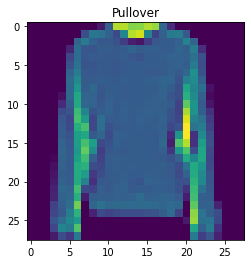

In [14]:
for image, label in train_dataset.take(1):
  break

image = image.numpy().reshape((28, 28))

# plot the figure
plt.title(class_names[label.numpy()])
plt.imshow(image)


## Build the model

In [15]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

## Lets train the model now!

In [17]:
BATCH_SIZE = 32
num_train_examples = len(train_dataset)

In [18]:
num_train_examples

60000

## Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()` (the `epochs` parameter described below limits how long we perform training).
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.

Training is performed by calling the `model.fit` method:
1. Feed the training data to the model using `train_dataset`.
2. The model learns to associate images and labels.
3. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

In [19]:
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [20]:
history = model.fit(train_dataset,
          epochs=5,
          steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4900 - accuracy: 0.8263
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3740 - accuracy: 0.8647
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3380 - accuracy: 0.8758
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3135 - accuracy: 0.8847
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2978 - accuracy: 0.8911


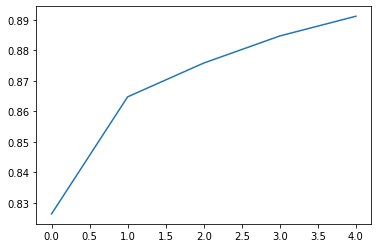

In [21]:
plt.plot(history.history["accuracy"])

## Lets evaluate our model now!

In [22]:
model.evaluate(test_dataset)

313/313 [==============================] - 2s 6ms/step - loss: 0.3563 - accuracy: 0.8704


[0.3562734127044678, 0.8704000115394592]

Accuracy of our model is 87.04%